In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from scipy.interpolate import griddata
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
timestamps = pd.read_csv('../data/gps_hh.csv')
timestamps['UniqueID'] = timestamps['UniqueID'].astype('int')
timestamps['j_time'] = pd.to_datetime(timestamps['j_time'],errors='ignore', infer_datetime_format=True)
timestamps.head()

,WKT,Label,UniqueID,WKT.1,j_ele,j_time,j_delorme_speed,j_delorme_heading,j_wkt_gps,distance,shot_bearing
0,POINT (538160.402827114 28086.3759010442),1,4979,Point (538160.40282711 28086.37590104),3.589226,2018-09-14 18:58:18,5.070254,74,PointZ (538211.06961683 28120.21718302 3.589226),60.929106,236.260309
1,POINT (538176.743357786 28054.4344546699),1,4981,Point (538176.74335779 28054.43445467),3.589226,2018-09-14 18:58:18,5.070254,74,PointZ (538211.06961683 28120.21718302 3.589226),74.200131,207.556122
2,POINT (540853.764605254 28358.7993798667),1,4,Point (540853.76460525 28358.79937987),7.132988,2018-09-14 19:03:55,19.698139,88,PointZ (540855.14992466 28326.65476584 7.132988),32.174451,357.532281
3,POINT (538270.971082187 27918.2856180771),1,4984,Point (538270.97108219 27918.28561808),3.814114,2018-09-14 18:58:50,0.813388,219,PointZ (538296.8838804 27943.6932731 3.814114),36.290798,225.563940
4,POINT (538231.960625197 27958.5745176459),1,4985,Point (538231.9606252 27958.57451765),3.703999,2018-09-14 18:59:04,6.395395,356,PointZ (538297.16447777 27959.32242283 3.703999),65.208142,269.342831


In [3]:
timestamps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 11 columns):
WKT                  87 non-null object
Label                87 non-null int64
UniqueID             87 non-null int64
WKT.1                87 non-null object
j_ele                87 non-null float64
j_time               87 non-null datetime64[ns]
j_delorme_speed      87 non-null float64
j_delorme_heading    87 non-null int64
j_wkt_gps            87 non-null object
distance             87 non-null float64
shot_bearing         87 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 7.6+ KB


In [4]:
def camera(picture, outputshape=(400, 400), theta=60, phi=-90, windowsize=(55, 55)):
    
    imgsize=picture.shape[0]
    orix, oriy = picture.shape[0]/2, picture.shape[1]/2
    
    map1 = []
    map2 = []
    
    #print(orix)
    
    # Mapping construction DESTINATION
    for x in range(outputshape[0]):
        for y in range(outputshape[1]):
            map2.append([x,y])
    #print(np.array(map2).shape)
    
    for p in np.linspace(phi-windowsize[1]/2, phi+windowsize[1]/2, outputshape[1]):
        for r in np.linspace(theta-windowsize[0]/2, theta+windowsize[0]/2, outputshape[0]):
            p1 = orix + (r/90*orix) * np.cos(p/180*np.pi)
            p2 = oriy + (r/90*orix) * np.sin(p/180*np.pi)
            map1.append([int(p1), int(p2)])

        
    grid_x, grid_y = np.mgrid[0:outputshape[0]:outputshape[0]*1j, 0:outputshape[1]:outputshape[0]*1j]
    grid_z = griddata(map2, map1, (grid_x, grid_y), method='cubic')
    map_x = np.append([], [ar[:,0] for ar in grid_z]).reshape(outputshape)
    map_y = np.append([], [ar[:,1] for ar in grid_z]).reshape(outputshape)
    map_x_32 = map_x.astype('float32')
    map_y_32 = map_y.astype('float32')
    
    trf = cv2.remap(picture,
                     map_x_32, map_y_32, 
                     cv2.INTER_LINEAR,)
    
    rows,cols = trf.shape[:2]

    M = cv2.getRotationMatrix2D((cols/2,rows/2),-90,1)
    dst = cv2.warpAffine(trf,M,(cols,rows))
    return dst
    

## Hand-held GPS version

In [5]:
timestamps.columns

Index(['WKT', 'Label', 'UniqueID', 'WKT.1', 'j_ele', 'j_time',
       'j_delorme_speed', 'j_delorme_heading', 'j_wkt_gps', 'distance',
       'shot_bearing'],
      dtype='object')

In [6]:
timestamps['clock'] = timestamps['j_time'] - timestamps['j_time'].dt.normalize()
timestamps['clock_sec'] = timestamps['clock'].apply(lambda x: x.total_seconds())
timestamps.head()

,WKT,Label,UniqueID,WKT.1,j_ele,j_time,j_delorme_speed,j_delorme_heading,j_wkt_gps,distance,shot_bearing,clock,clock_sec
0,POINT (538160.402827114 28086.3759010442),1,4979,Point (538160.40282711 28086.37590104),3.589226,2018-09-14 18:58:18,5.070254,74,PointZ (538211.06961683 28120.21718302 3.589226),60.929106,236.260309,18:58:18,68298.0
1,POINT (538176.743357786 28054.4344546699),1,4981,Point (538176.74335779 28054.43445467),3.589226,2018-09-14 18:58:18,5.070254,74,PointZ (538211.06961683 28120.21718302 3.589226),74.200131,207.556122,18:58:18,68298.0
2,POINT (540853.764605254 28358.7993798667),1,4,Point (540853.76460525 28358.79937987),7.132988,2018-09-14 19:03:55,19.698139,88,PointZ (540855.14992466 28326.65476584 7.132988),32.174451,357.532281,19:03:55,68635.0
3,POINT (538270.971082187 27918.2856180771),1,4984,Point (538270.97108219 27918.28561808),3.814114,2018-09-14 18:58:50,0.813388,219,PointZ (538296.8838804 27943.6932731 3.814114),36.290798,225.563940,18:58:50,68330.0
4,POINT (538231.960625197 27958.5745176459),1,4985,Point (538231.9606252 27958.57451765),3.703999,2018-09-14 18:59:04,6.395395,356,PointZ (538297.16447777 27959.32242283 3.703999),65.208142,269.342831,18:59:04,68344.0


In [7]:
6*60+.353-29.191

331.16200000000003

In [8]:
13*60+54-8*60-23

331

In [32]:
def snapshots(videopath, df,
              timestampref = [1, 4*60+2], # 2 or more references on the video
             gpsrefid = [2, 4], # Same references on the handheld device IN SECONDS
             anglecorrection = 15):
    
    reg = LinearRegression().fit(np.array(gpsrefid).reshape(-1,1), np.array(timestampref).reshape(-1,1))
    #print(reg.coef_)
    
    vidcap = cv2.VideoCapture(videopath)
    success, image = vidcap.read()


    for index, house in df.iterrows(): #.iloc[[15, 12, 10, 37]]
        uid = int(house['UniqueID'])
        if house.j_delorme_speed > 5 and house.distance <50:
            #frame_no = house['timestamp']*1000  #In Milli-seconds
            frame_no = reg.predict(np.array(house['clock_sec']).reshape(-1,1))[0][0]*1000
            print(int(frame_no)/1000, house['shot_bearing'], house['j_delorme_heading'])

            # CAPTURE EXTRACTION
            vidcap.set(cv2.CAP_PROP_POS_MSEC,frame_no)
            success, image = vidcap.read()
            #cv2.imwrite("../exports/{} - {} - frame.jpg".format(uid, int(frame_no)), image)
            
            # PICTURE ROTATION
            angle=house['j_delorme_heading']
            center=tuple(np.array(image.shape[0:2])/2)
            rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
            image = cv2.warpAffine(image, rot_mat, image.shape[0:2],flags=cv2.INTER_LINEAR)
            #cv2.imwrite("../exports/{} - {} - rot-frame.jpg".format(uid, int(frame_no)), image)
            
            # PICTURE MIRORING
            image = cv2.flip( image, 1 )
            #cv2.imwrite("../exports/{} - {} - mir-frame.jpg".format(uid, int(frame_no)), image)
            
            # PICTURE UNWARPING
            angle = -90 + house['shot_bearing'] - anglecorrection
            print(angle)
            house = camera(image, theta=55, phi=angle)
            cv2.imwrite("../exports/{} - {} - house.jpg".format(uid, int(frame_no)), house)

            print('uid:{} Done'.format(uid))
            print()
        else:
            print('House {} skipped beccause of low speed'.format(uid))
            
        
    
    print('done')
    
snapshots('../video/FLY70001.MP4', timestamps, timestampref=[29.191, 6*60+0.353], gpsrefid=[18*3600+58*60+23, 19*3600+3*60+54])

House 4979 skipped beccause of low speed
House 4981 skipped beccause of low speed
361.353 357.532281149465 88
252.532281149465
uid:4 Done

House 4984 skipped beccause of low speed
House 4985 skipped beccause of low speed
74.213 262.834603661883 1
157.83460366188302
uid:4986 Done

House 4987 skipped beccause of low speed
41.196 266.038182552652 179
161.03818255265202
uid:4988 Done

26.189 187.94530656673402 63
82.94530656673402
uid:4989 Done

House 4337 skipped beccause of low speed
250.299 352.008925695103 91
247.00892569510302
uid:5127 Done

390.367 96.5714784916052 0
-8.428521508394795
uid:5391 Done

39.195 95.2384968729579 179
-9.761503127042104
uid:4744 Done

105.228 266.522064426298 180
161.52206442629802
uid:4745 Done

House 5139 skipped beccause of low speed
45.198 85.27918115765941 179
-19.72081884234059
uid:4746 Done

House 4747 skipped beccause of low speed
131.24 88.90612368721149 7
-16.09387631278851
uid:4748 Done

137.243 88.3190380727462 1
-16.680961927253804
uid:4749 Don

# Left-Right version

In [46]:
# Left- right- front version

def snapshots(videopath, timestamps, uniqueid, bearingcorrect=12):
    vidcap = cv2.VideoCapture(videopath)
    success,image = vidcap.read()

    #frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    #fps=vidcap.get(cv2.CAP_PROP_FPS)
    #duration = frame_count/fps


    for timestamp, uid in zip(timestamps[:3], uniqueid[:3]):
        frame_no = timestamp*1000  #In Milli-seconds
        #print(timestamp, ' - ', frame_no)
        vidcap.set(cv2.CAP_PROP_POS_MSEC,frame_no)
        success, image = vidcap.read()
        
        rows,cols = image.shape[:2]

        M = cv2.getRotationMatrix2D((cols/2,rows/2),bearingcorrect,1)
        image = cv2.warpAffine(image,M,(cols,rows))
        
        cv2.imwrite("../exports/{} - {} - frame.jpg".format(int(uid),int(timestamp*1000)), image)
        
        left = camera(image, theta=55, phi=0)
        cv2.imwrite("../exports/{} - {} - left.jpg".format(int(uid),int(timestamp*1000)), left)
        
        right = camera(image, theta=55, phi=180)
        cv2.imwrite("../exports/{} - {} - right.jpg".format(int(uid), int(timestamp*1000)), right)
        
        front = camera(image, theta=55, phi=-90)
        cv2.imwrite("../exports/{} - {} - front.jpg".format(int(uid), int(timestamp*1000)), front)
        
        print('uid:{} Done'.format(int(uid)))
        
    
    print('done')

In [47]:
snapshots('../video/FLY70001.MP4', timestamps['join_Timestamp(sec)'], timestamps['UniqueID'], bearingcorrect=12)

uid:0 Done
uid:1 Done
uid:2 Done
uid:3 Done
uid:4 Done
uid:5 Done
uid:6 Done
uid:7 Done
uid:8 Done
uid:9 Done
uid:10 Done
uid:11 Done
uid:12 Done
uid:13 Done
uid:14 Done
uid:15 Done
uid:16 Done
uid:17 Done
uid:18 Done
uid:19 Done
done


# Angle version

In [17]:
timestamps.columns

Index(['WKT', 'Label', 'UniqueID', 'WKT.1', 'j_ele', 'j_time',
       'j_delorme_speed', 'j_delorme_heading', 'j_wkt_gps', 'distance',
       'shot_bearing'],
      dtype='object')

In [6]:
df = timestamps.copy()
df.columns = ['UniqueID', 'houseWKT', 'timestamp', 'speed', 'azcamera', 'cameraWKT', 'distance', 'Shot_angle']
df.head()

,UniqueID,houseWKT,timestamp,speed,azcamera,cameraWKT,distance,Shot_angle
0,4979.0,POINT (538160.40282711 28086.37590104),18.870,10.04,0.2,Point (538202.52273602 28093.67201382),42.747164,4.540869
1,4981.0,POINT (538176.74335779 28054.43445467),14.808,11.43,0.2,Point (538203.00984498 28049.90085254),26.654866,4.883305
2,4.0,POINT (540853.76460525 28358.79937987),362.367,20.01,90.1,Point (540861.08244393 28328.69434778),30.981667,6.044733
3,4984.0,POINT (538270.97108219 27918.28561808),57.415,1.30,242.5,Point (538295.6745664 27945.77166298),36.955985,3.873725
4,4985.0,POINT (538231.9606252 27958.57451765),0.651,0.00,0.0,Point (538209.89627631 27969.09128835),24.442544,2.015583


In [7]:
for index, house in df[:3].iterrows():
    print(int(house['UniqueID']))

4979
4981
4


In [8]:
# Angle version

def snapshots(videopath, df, balancecorrection = 0, distancefactor=0):
    vidcap = cv2.VideoCapture(videopath)
    success, image = vidcap.read()


    for index, house in df.iloc[[15, 12, 10, 37]].iterrows(): #.iloc[[15, 12, 10, 37]]
        uid = int(house['UniqueID'])
        print('speed', house.speed)
        print('timestamp', house.timestamp*1000)
        if house.speed > 5:
            frame_no = house['timestamp']*1000  #In Milli-seconds
            
            print(np.degrees(house['Shot_angle']), house['azcamera'])

            #angle = (house['Shot_angle'] - house['azcamera']/180*np.pi)*90/np.pi +90


            vidcap.set(cv2.CAP_PROP_POS_MSEC,frame_no)
            success, image = vidcap.read()

            #cv2.imwrite("../exports/{} - {} - frame.jpg".format(uid, int(frame_no)), image)

            #angle = (np.degrees(house['Shot_angle']))
            #angle = -(180-(90-house.azcamera)-np.degrees(house.Shot_angle))
            
            #Camera correction
            angle1 = -house.azcamera
            
            #Mirror angle to the vertical
            angle2 = 180 - angle1
            
            #Convert in OpenCV
            angle = angle2 +90
            print(360-(angle))

            house = camera(image, theta=55, phi=angle)
            cv2.imwrite("../exports/{} - {} - house.jpg".format(uid, int(frame_no)), house)


            #front = camera(image, theta=55, phi=-90)
            #cv2.imwrite("../exports/{} - {} - front.jpg".format(int(uid), int(timestamp*1000)), front)

            print('uid:{} Done'.format(uid))
            print()
        else:
            print('House {} skipped beccause of low speed'.format(uid))
            
        
    
    print('done')
    
snapshots('../video/FLY70001.MP4', df)

speed 10.54
timestamp 46247.0
83.88823678882721 179.6
-89.60000000000002
uid:4746 Done

speed 9.0
timestamp 40168.0
98.60990175048882 181.7
-91.69999999999999
uid:4744 Done

speed 20.82
timestamp 249945.0
14.603876578902668 89.09999999999998
0.9000000000000341
uid:5127 Done

speed 17.36
timestamp 230685.0
25.875133100466776 124.3
-34.30000000000001
uid:4763 Done

done


In [16]:
df[df['UniqueID']==4746]

,UniqueID,houseWKT,timestamp,speed,azcamera,cameraWKT,distance,Shot_angle
15,4746.0,POINT (538317.67694599 28017.61069401),46.247,10.54,179.6,Point (538298.27067365 28015.53273195),19.517206,1.464126


In [55]:
df.iloc[[29,35,68]]

,UniqueID,timestamp,azshot,azcamera
29,29.0,249.945,5.944354,1.555088
35,35.0,208.400,1.918414,0.022689
68,68.0,284.355,5.727829,1.577778


In [135]:
221-45

176

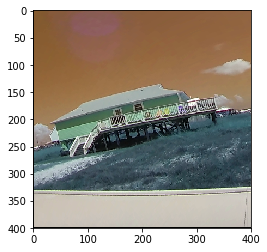

In [21]:
picture = cv2.imread('../exports/4746 - 46247 - frame.jpg')
plt.imshow(camera(picture, theta=60, phi=45))
plt.show()


In [129]:
timestamps[timestamps['join_Speed'] <=1]

,UniqueID,WKT,join_Times,join_Speed,join_Beari,join_WKT_c,distance,Shot_angle
4,4985.0,POINT (538231.9606252 27958.57451765),0.651,0.00,0.0,Point (538209.89627631 27969.09128835),24.442544,2.015583
9,4337.0,POINT (538201.88048334 27944.66741691),1.658,0.00,0.0,Point (538209.16322187 27969.30686853),25.693206,3.428982
16,4747.0,POINT (538365.69101774 27925.90141263),120.259,0.93,280.4,Point (538386.81673603 27962.17352021),41.975728,3.668988
41,4637.0,POINT (538175.1943106 27963.00468157),2.674,0.00,0.0,Point (538208.43016746 27969.52244876),33.868916,4.518740
43,4638.0,POINT (538219.40199667 27928.8507072),0.651,0.00,0.0,Point (538209.89627631 27969.09128835),41.348072,2.909623
74,5090.0,POINT (538363.79949417 27956.73421128),120.259,0.93,280.4,Point (538386.81673603 27962.17352021),23.651205,4.480332


# House panoramique

In [6]:
timestamps = pd.read_csv('../Metadata/video_house_pan_7001.csv')
timestamps.head()

,Type,Mode,Timestamp(sec),Latitude,Longitude,Altitude,Speed(m/s),Bearing,Accuracy,bearing_rad,join_SiteId,join_BuildingTy,join_Label,join_UniqueID,join_point_crd,distance,shot_bearing,bearing_shot
0,5,16,0.651,30.25075,-88.14206,40,0.00,0.0,5,0.00000,6,0,NaN,12,Point (538231.9606252 27958.57451765),24.442544,2.015583,2
1,5,16,1.658,30.25075,-88.14207,33,0.00,0.0,5,0.00000,6,0,NaN,12,Point (538231.9606252 27958.57451765),25.197320,2.010788,2
2,5,16,2.674,30.25075,-88.14207,30,0.00,0.0,5,0.00000,6,0,NaN,2,Point (538201.88048334 27944.66741691),25.703521,3.399251,3
3,5,16,3.683,30.25075,-88.14206,31,0.55,43.2,5,0.75398,6,0,NaN,12,Point (538231.9606252 27958.57451765),24.718899,2.038811,2
4,5,16,4.690,30.25076,-88.14205,32,1.64,28.7,5,0.50091,6,0,NaN,12,Point (538231.9606252 27958.57451765),24.671048,2.098144,2


In [7]:
df = timestamps[['join_UniqueID', 'Timestamp(sec)', 'shot_bearing', 'bearing_rad']]
df.columns = ['UniqueID', 'timestamp', 'azshot', 'azcamera']
df.head()

,UniqueID,timestamp,azshot,azcamera
0,12,0.651,2.015583,0.00000
1,12,1.658,2.010788,0.00000
2,2,2.674,3.399251,0.00000
3,12,3.683,2.038811,0.75398
4,12,4.690,2.098144,0.50091


In [41]:
# Angle version

def snapshots(videopath, df, houseid):
    vidcap = cv2.VideoCapture(videopath)
    success, image = vidcap.read()

    subset = df[df['UniqueID'] == houseid]

    for index, house in subset.iterrows():
        frame_no = house['timestamp']*1000  #In Milli-seconds
        uid = int(house['UniqueID'])
        
        azshot = house.azshot
        azcamera = house.azcamera

        sinh = np.sin(azshot)
        cosh = np.cos(azshot)
        sinc = np.sin(azcamera)
        cosc = np.cos(azcamera)

        if sinc == 0:
            cam = (np.pi/2) * np.sign(cosc)
        elif cosc == 0:
            cam = (np.pi) * -(np.sign(sinc)/2 - .5)
        else:
            cam = np.arctan(cosc/sinc) + (-(np.sign(sinc)/2 - .5))*np.pi

        if sinh == 0:
            shot = (np.pi/2) * np.sign(cosh)
        elif cosc == 0:
            shot = (np.pi) * -(np.sign(sinh)/2 - .5)
        else:
            shot = np.arctan(cosh/sinh) + (-(np.sign(sinh)/2 - .5))*np.pi       
        
        angle = np.degrees(shot - cam) - 90
        
        vidcap.set(cv2.CAP_PROP_POS_MSEC,frame_no)
        success, image = vidcap.read()
        
        cv2.imwrite("../exports/zz - {} - {} - frame.jpg".format(uid, int(frame_no)), image)
        
        
        house = camera(image, theta=55, phi=angle)
        cv2.imwrite("../exports/{} - {} - house.jpg".format(uid, int(frame_no)), house)

        
        #front = camera(image, theta=55, phi=-90)
        #cv2.imwrite("../exports/{} - {} - front.jpg".format(int(uid), int(timestamp*1000)), front)
        
        print('uid:{} - tstp:{} Done, ANGLE = {}'.format(uid, frame_no, angle))
        
    
    print('done')
    
snapshots('../video/FLY70001.MP4', df, 65)

uid:65 - tstp:260081.00000000003 Done, ANGLE = -76.15301544696591
uid:65 - tstp:261098.0 Done, ANGLE = -73.97861445376276
uid:65 - tstp:262105.00000000003 Done, ANGLE = -71.10645440582053
uid:65 - tstp:263115.0 Done, ANGLE = -67.40973100617173
uid:65 - tstp:264123.0 Done, ANGLE = -62.33803141570628
uid:65 - tstp:265146.0 Done, ANGLE = -54.9760909750639
uid:65 - tstp:266169.0 Done, ANGLE = -44.59340653894852
uid:65 - tstp:267177.0 Done, ANGLE = -27.96542445494532
uid:65 - tstp:268182.0 Done, ANGLE = -3.672557249074387
uid:65 - tstp:269189.0 Done, ANGLE = 18.953283069706742
done


In [40]:
df[df['UniqueID'] == 65]

,UniqueID,timestamp,azshot,azcamera
256,65,260.081,1.330865,1.57254
257,65,261.098,1.292914,1.57254
258,65,262.105,1.242785,1.57254
259,65,263.115,1.180015,1.57429
260,65,264.123,1.100218,1.58301
261,65,265.146,0.973477,1.58476
262,65,266.169,0.794005,1.58650
263,65,267.177,0.503792,1.58650
264,65,268.182,0.085042,1.59174
265,65,269.189,5.971582,1.58999
